# Taxonomic assignment: Downstream analyses

In [ ]:
# !pip install openpyxl
# !pip install venn

In [1]:
# load modules
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from venn import venn
from openpyxl.workbook import Workbook

/home/lubo/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [9]:
# load dataset function

def load_summary_to_df(marker, cell, sim):
    """loading summary taxonomic assignment table into a dataframes"""
    raw_data="../raw_data"
    data_path=f"{raw_data}/OTU_summary_tables/otu_summary_table_{marker}_{cell}_{sim}.tsv"
    return pd.read_csv(data_path, sep="\t")

sum_tables={"cell1_sim97": "", 
                "cell1_sim99": "", 
                "cell2_sim97": "", 
                "cell2_sim99": "",
                "cellCombined_sim97": "",
                "cellCombined_sim99": ""}

def load_summary_to_dict(sum_tables=sum_tables):
    """load summary taxonomic assignment table into a dictionary"""
    for dataset in sum_tables:
        cell, sim = dataset.split("_")
        sum_tables[dataset]=load_summary_to_df("Full18S", cell, sim)
    return sum_tables

## Summary tables

In [ ]:
sum_tables=load_summary_to_dict()

In [ ]:
# save all the summary table as excel tables
marker="Full18S"
data_path="../raw_data/OTU_summary_tables"

for dataset in sum_tables:
    cell, sim = dataset.split("_")
    sum_tables[dataset].to_excel(f"{data_path}/OTU_summary_table_{marker}_{cell}_{sim}.xlsx")

In [ ]:
samples=['A3', 'Mock', 'NH1', 'NH4', 'Sim17', 'Sim22', 'Th16', 'Th38',
       'Th40', 'X17007']

# creating a dictonary with sample names where we will store abundance information for each sample
abundance = {}
for sample in samples:
    abundance[sample] = []

# loop through each dataset and calculate number of unique OTUs for each sample
for dataset in sum_tables:
    for sample_name in samples:
        abundance[f'{sample_name}'].append(len(sum_tables[dataset][sum_tables[dataset][f'{sample_name}'] != 0]))
    
unique_otus = pd.DataFrame(data=abundance, index=sum_tables.keys())
unique_otus

In [ ]:
# number of unique OTUs for all samples together
unique_otus["total"] = unique_otus.iloc[0:9].sum(axis=1)
unique_otus

## Inspecting how abundances declined through the pipeline (per sample)

Changing number of features (reads, asvs, otus) through the pipeline
Steps in pipelines:
- raw reads
- denoise (filter, denoise, chimeric seqs)
- OTU custering
- otu filter.

### Denoise table

In [ ]:
raw_data="../raw_data"
datasets=["cell1", "cell2", "cellCombined"]

df_denoise={}

for dataset in datasets:
    df_denoise[dataset]=pd.read_csv(f"{raw_data}/denoise/Full18S/{dataset}/asv_stats.tsv", sep="\t")
    df_denoise[dataset]=df_denoise[dataset][["sample-id", "input", "primer-removed", "filtered", "denoised", "non-chimeric"]]
    df_denoise[dataset]=df_denoise[dataset].tail(-1)
    df_denoise[dataset]=df_denoise[dataset].rename(columns={"sample-id": "sample_id", "input": "raw_reads", "input": "raw_reads", "filtered": "asv_filtered"})
    id_splited=df_denoise[dataset]['sample_id'].str.split(pat="_", expand=True)
    df_denoise[dataset]["sample_id"]=id_splited[0]
    df_denoise[dataset]=df_denoise[dataset].set_index("sample_id")

In [ ]:
df_denoise["cellCombined"]

### OTU clustering table

In [ ]:
raw_data="../raw_data"
datasets=["cell1", "cell2", "cellCombined"]

df_otu={}

for dataset in datasets:
    df_otu[dataset]=pd.read_csv(f"{raw_data}/OTU_clust/Full18S/{dataset}/sim99/feature_count.tsv", sep="\t")
    id_splited=df_otu[dataset]['Sample_ID'].str.split(pat="_", expand=True)
    df_otu[dataset]['Sample_ID']=id_splited[0]
    df_otu[dataset]=df_otu[dataset].rename(columns={"Sample_ID": "sample_id", "Feature_Count": "otu_clustered"})
    df_otu[dataset]=df_otu[dataset].set_index("sample_id")

In [ ]:
df_otu["cellCombined"]

### OTU filtering table

In [ ]:
# changing number of features (reads, asvs, otus) through the pipeline
# steps in pipelines: raw reads, denoise, otu, otu filter

In [ ]:
raw_data="../raw_data"
datasets=["cell1", "cell2", "cellCombined"]

df_otu_filt={}

for dataset in datasets:
    df_otu_filt[dataset]=pd.read_csv(f"{raw_data}/OTU_filtered/Full18S/{dataset}/sim99/feature_count.tsv", sep="\t")
    id_splited=df_otu_filt[dataset]['Sample_ID'].str.split(pat="_", expand=True)
    df_otu_filt[dataset]['Sample_ID']=id_splited[0]
    df_otu_filt[dataset]=df_otu_filt[dataset].rename(columns={"Sample_ID": "sample_id", "Feature_Count": "otu_filt_sim99"})
    df_otu_filt[dataset]=df_otu_filt[dataset].set_index("sample_id")

In [ ]:
df_otu_filt["cellCombined"]

### Merging all tables together

In [ ]:
datasets=["cell1", "cell2", "cellCombined"]

df_abundances={}

for dataset in datasets:
    df_abundances[dataset]=df_denoise[dataset] \
    .merge(df_otu[dataset], left_index=True, right_index=True) \
    .merge(df_otu_filt[dataset], left_index=True, right_index=True)
    df_abundances[dataset]=df_abundances[dataset].astype(int)

In [ ]:
df_abundances["cellCombined"]

In [ ]:
# save the final table to an excel file

path="../raw_data/OTU_summary_tables"

with pd.ExcelWriter(f"{path}/abundances.xlsx") as writer:  
    df_abundances["cell1"].to_excel(writer, sheet_name="cell1")
    df_abundances["cell2"].to_excel(writer, sheet_name="cell2")
    df_abundances["cellCombined"].to_excel(writer, sheet_name="cellCombined")

## Inspecting how abundances declined through the pipeline (all samples together)

In [ ]:
datasets=["cell1", "cell2", "cellCombined"]

df_abundances_total={}

for dataset in datasets:
    df_abundances_total[dataset] = df_abundances[dataset].sum(axis=0).to_frame().reset_index()
    df_abundances_total[dataset] = df_abundances_total[dataset].rename(columns= {0: 'total'})

In [ ]:
df_abundances_total["cell1"]

In [ ]:
dataset="cell2"
path="../raw_data/OTU_summary_tables"



sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("white")
abund_bar=sns.barplot(x="index", y="total", data=df_abundances_total[dataset], palette="rocket");
abund_bar.set(xlabel="", ylabel = "Abundance", title =f"Decline of abundances throughout the pipeline")
abund_bar.set_xticklabels(["Raw reads", 
                           "Primers\nfiltering", 
                           "Length\nfiltering", 
                           "ASV\ndenoised", 
                           "Chimeras\nremoved",
                           "OTU\nclustered",
                           "OTU\nfiltered"])
sns.despine()

# plt.savefig(f"{path}/abundance_{dataset}.png", dpi=300, transparent=False)

## Reducing number of representative sequences throughout the pipeline

We used three steps that reduce number of the features (representative sequences) in our pipeline:

1. **Denoising raw sequences:** primers and length filtering, denoising, chimeras filtering
2. **OTU clustering:** based on 97 and 99 similarity threshold
3. **OTU filtering:** filtering out taxonomically unassigned OTUs at phyllum level and filtering out rare OTUs

Let's check how many unique number of features was reduced during these three steps.

In [ ]:
datasets=["cell1", "cell2", "cellCombined"]
denoise_path="../raw_data/denoise/Full18S"
otu_clust_path="../raw_data/OTU_clust/Full18S"
otu_filt_path="../raw_data/OTU_filtered/Full18S"
sim="sim99"

# creating dictionary where we will append the values in the loop below for our table
rep_seqs_data={"denoised": [],
               "OTU_clustered": [],
               "OTU_filtered": []}

# gathering information for the table
for dataset in datasets:
    
    # gather the total number of unique ASVs
    with open(f"{denoise_path}/{dataset}/asv_seqs.fasta", 'r') as file:
        denoised_fasta = file.read()
    rep_seqs_data["denoised"].append(denoised_fasta.count(">"))
    
    # gather the total number of unique OTUs
    with open(f"{otu_clust_path}/{dataset}/{sim}/otu_seqs.fasta", 'r') as file:
        otu_clust_fasta = file.read()
    rep_seqs_data["OTU_clustered"].append(otu_clust_fasta.count(">"))
    
    # gather the total number of unique OTUs after filtering
    with open(f"{otu_filt_path}/{dataset}/{sim}/otu_seqs_filtered.fasta", 'r') as file:
        otu_filt_fasta = file.read()
    rep_seqs_data["OTU_filtered"].append(otu_filt_fasta.count(">"))
    

# creating the final table that we will populate with data gather in the loop above
rep_seqs=pd.DataFrame(data=rep_seqs_data, index=["cell1", "cell2", "cellCombined"])
rep_seqs

In [ ]:
# bar plot of decreasing unique representative sequences after individual steps in the pipeline
path="../raw_data/OTU_summary_tables"

# adjusting the data table for plotting
df_plot=rep_seqs.reset_index()
df_plot=df_plot.melt(id_vars=['index'], value_vars=['denoised', 'OTU_clustered', 'OTU_filtered'])

# plotting code
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("white")
repseq_bar=sns.barplot(data=df_plot, x="variable", y="value", hue="index")
repseq_bar.set(xlabel="", 
                ylabel = "number of representative sequences", 
                title =f"")
repseq_bar.set_xticklabels(["ASV denoised", "OTU clustered", "OTU filtered"])
sns.despine()

# adjusting legend
h, l = repseq_bar.get_legend_handles_labels()
repseq_bar.legend(handles=h, 
                  labels=["Cell 1", "Cell 2", "Combined Cells"], 
                  title="Flow Cell", 
                  loc="upper right", 
                  frameon=False);

# save
plt.savefig(f"{path}/unique_representative_sequences.png", dpi=300, transparent=False)

## Vampyrella specific data

We want to:
- check how many vampyrellid taxa were found in individual samples and in total
- how clustering thresholds affect number of vampyrellid taxa in mock community
- how filtering rare OTUs affect number of vampyrellid taxa in mock community

We supposed to find five taxa (different species) in mock sample

### Vampyrellid ASVs, OTUs, and OTUs with filtered rare sequences out

In [13]:
# defining a few functions for loading data and adjusting datasets for plotting data

def read_into_dic(dataset_names, input_dir, marker="Full18S"):
    """read tsv summary tables as dataframes and save them into a dictionary.
    Each dataframe will represent a key in the dictionary.
    Provide a list with dataset names as input file in the following pattern:
    cell_sim. Also provide a path to the directory with the summary tables"""
    dictionary=dict.fromkeys(dataset_names, "")
    for dataset in dictionary:
        cell, sim = dataset.split("_")
        data_path=f"{input_dir}/otu_summary_table_{marker}_{cell}_{sim}.tsv"
        dictionary[dataset]=pd.read_csv(data_path, sep="\t")
    return dictionary

def filt_vamp(dataset_dict):
    """filtered only vampyrellida ASVs for each dataframe and 
    save it into new a dictionary"""
    vamp_spec_dict={}
    for dataset in dataset_dict.keys():
        vamp_spec_dict[dataset]=dataset_dict[dataset][dataset_dict[dataset]["Order"] == "Vampyrellida"]
    return vamp_spec_dict

def num_otus_allsample(vamp_spec_dict):
    """create a dataframe with total number of vampyrellid OTUs 
    found in each dataset for all samples combined"""
    data_for_table={"num_otus": []}
    for dataset in vamp_spec_dict.keys():
        data_for_table["num_otus"].append(vamp_spec_dict[dataset].shape[0])
    return pd.DataFrame(data=data_for_table, index=vamp_spec_dict.keys())

def num_otus_persample(samples, vamp_spec_dict):
    """create a dataframe with total number of vampyrellid OTUs 
    found in each dataset and each sample. Provide: i) list of samples,
    ii) dictionary with individual datasets."""
    data_for_table={"sample": [],
                    "num_otus": [], 
                    "dataset": []}
    for dataset in vamp_spec_dict.keys():
        current_dataset = vamp_spec_dict[dataset]
        for sample in samples:
            data_for_table["sample"].append(sample)
            individual_sample=current_dataset[current_dataset[sample] != 0]
            data_for_table["num_otus"].append(individual_sample.shape[0])
            data_for_table["dataset"].append(dataset)
    return pd.DataFrame(data=data_for_table)

In [ ]:
# variables
input_dir_unfilt="../raw_data/OTU_summary_tables/unfiltered"
input_dir_filt="../raw_data/OTU_summary_tables"
samples=['A3', 'Mock', 'NH1', 'NH4', 'Sim17', 'Sim22', 'Th16', 'Th38', 'Th40', 'X17007']
dataset_names=["cell1_sim97", "cell1_sim99", "cell2_sim97", "cell2_sim99", "cellCombined_sim97", "cellCombined_sim99"]


# load summary tables as dataframes
sum_tables_filt = read_into_dic(dataset_names=dataset_names, input_dir=input_dir_filt)

sum_tables_unfilt = read_into_dic(dataset_names=dataset_names, input_dir=input_dir_unfilt)


# retrain only vampyrellida ASVs
vamp_filt = filt_vamp(sum_tables_filt)
vamp_unfilt = filt_vamp(sum_tables_unfilt)


# creating table with total number of vampyrellid OTUs found in each dataset and all samples combined   
vamp_filt_allsamples=num_otus_allsample(vamp_filt)
vamp_unfilt_allsamples=num_otus_allsample(vamp_unfilt)

# creating a table with total number of vampyrellid OTUs found in each sample and each dataset
vamp_filt_persample = num_otus_persample(vamp_spec_dict=vamp_filt, samples=samples)
vamp_unfilt_persample = num_otus_persample(vamp_spec_dict=vamp_unfilt, samples=samples)

In [ ]:
# plotting all sample combined results

path="../raw_data/OTU_summary_tables"
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(11.7,8.27))
sns.set_style("white")

# vamp unfilt allsamples
vamp_unfilt_plot=sns.barplot(ax=axes[0], x=vamp_unfilt_allsamples.index, 
                            y="num_otus", 
                            data=vamp_unfilt_allsamples, 
                            palette="colorblind")
axes[0].set_title("rare OTUs included")

# vamp filt allsamples
vamp_filt_plot=sns.barplot(ax=axes[1], x=vamp_filt_allsamples.index, 
                            y="num_otus", 
                            data=vamp_filt_allsamples, 
                            palette="colorblind")
axes[1].set_title("rare OTUs filtered out")

vamp_filt_plot.set_xticklabels(["cell 1\nsim 97",
                                 "cell 1\nsim 99",
                                 "cell 2\nsim 97",
                                 "cell 2\nsim 99",
                                 "comb.\nsim 97",
                                 "comb.\nsim 99"])

vamp_unfilt_plot.set(xlabel="", ylabel = "number of OTUs")
vamp_filt_plot.set(xlabel="", ylabel = "")
sns.despine()

plt.savefig(f"{path}/number_of_vamp_otus_allsamples.png", dpi=300, transparent=False)

In [ ]:
# plotting per sample results

path="../raw_data/OTU_summary_tables"
dataset_labels=["cell 1, similarity 97",
                "cell 1, similarity 99",
                "cell 2, similarity 97",
                "cell 2, similarity 99",
                "combined cells, similarity 97",
                "combined cells, similarity 99"]


fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(11.7,8.27))
sns.set_style("white")

# vamp unfilt allsamples
vamp_unfilt_plot=sns.barplot(ax=axes[0], data=vamp_unfilt_persample,
                                y="sample",
                                x="num_otus",
                                hue="dataset",
                                palette="colorblind")
axes[0].set_title("rare OTUs included")

# vamp filt allsamples
vamp_filt_plot=sns.barplot(ax=axes[1], data=vamp_filt_persample,
                                y="sample",
                                x="num_otus",
                                hue="dataset",
                                palette="colorblind")
axes[1].set_title("rare OTUs filtered out")



# adjusting legend
h, l = vamp_filt_plot.get_legend_handles_labels()
vamp_filt_plot.legend(handles=h, 
                           labels=dataset_labels, 
                           title="Dataset", 
                           loc='lower right', 
                           frameon=False);

vamp_unfilt_plot.legend([],[], frameon=False)

vamp_unfilt_plot.set(xlabel="", ylabel="sample ID")
vamp_filt_plot.set(xlabel="", ylabel = "")


fig.text(0.5, 0.05, 'number of OTUs', ha='center')

sns.despine()

plt.savefig(f"{path}/number_of_vamp_otus_persample.png", dpi=300, transparent=False)

### Visualize vampyrellid OTUs that were filtered out based on their abundance

In [ ]:
# variables
input_dir_unfilt="../raw_data/OTU_summary_tables/unfiltered"
input_dir_filt="../raw_data/OTU_summary_tables"
samples=['A3', 'Mock', 'NH1', 'NH4', 'Sim17', 'Sim22', 'Th16', 'Th38', 'Th40', 'X17007']
dataset_names=["cell1_sim97", "cell1_sim99", "cell2_sim97", "cell2_sim99", "cellCombined_sim97", "cellCombined_sim99"]


# load summary tables as dataframes
sum_tables_filt = read_into_dic(dataset_names=dataset_names, input_dir=input_dir_filt)

sum_tables_unfilt = read_into_dic(dataset_names=dataset_names, input_dir=input_dir_unfilt)


# retrain only vampyrellida ASVs
vamp_filt = filt_vamp(sum_tables_filt)
vamp_unfilt = filt_vamp(sum_tables_unfilt)

In [ ]:
# create a dataframe for each dataset with the following columns:
    # OTU ID
    # total OTU abundance
    # information on OTU was filtred out or not
    # dataset name
# and save each dataframe into the abundance_dict dictionary

abundance_dict = {}
sample="Total"

for dataset in vamp_filt.keys():
    unfilt=vamp_unfilt[dataset][["ID", sample]]
    filt=vamp_filt[dataset][["ID", sample]]
    merged=unfilt.merge(filt.drop_duplicates(), on=["ID"], how='left', indicator=True)
    merged=merged.drop(columns=[f"{sample}_y"])
    merged=merged.rename(columns={f"{sample}_x": "abundance", "_merge": "filtered_out"})
    merged["filtered_out"]=merged["filtered_out"].map({"left_only": "removed", "both": "retained"})
    merged["dataset"]=f"{dataset}"
    abundance_dict[dataset]=merged


df_abundance=pd.concat(abundance_dict.values())

In [ ]:
# plotting: vampyrellid OTUs that were filtered out based on their abundance

path="../raw_data/OTU_summary_tables"


sns.set_style("white")

palette = {'removed': "#D81B60", "retained": "#1E88E5"}

abundance_plot=sns.catplot(data=df_abundance, 
                            x="dataset", 
                            y="abundance",
                            hue="filtered_out", 
                            palette=palette,  size=5, aspect=1.4)


abundance_plot.set_xticklabels(["cell 1\nsim 97",
                                 "cell 1\nsim 99",
                                 "cell 2\nsim 97",
                                 "cell 2\nsim 99",
                                 "comb.\nsim 97",
                                 "comb.\nsim 99"])

abundance_plot.set(xlabel="dataset", ylabel = "abundance")

sns.move_legend(abundance_plot, title="", loc="center right")
# plt.yscale('log')


sns.despine()

plt.savefig(f"{path}/filtered_vs_retained_vamp_OTUs_mock.png", dpi=300, transparent=False)

In [ ]:
# Save the list of removed and retained OTUs for combinedCell similarity99 dataset as excel

path="../raw_data/OTU_summary_tables"

removed_vs_retained=abundance_dict["cellCombined_sim99"]. \
                    sort_values(by="abundance", ascending=False). \
                    drop(columns=["dataset"])

removed_vs_retained.to_excel(f"{path}/filtered_vs_retained_table_cellComb_sim99.xlsx", index=False)

## Venn diagrams

We want to determine how many OTUs are unique for each dataset/flows cells (cell1, cell2, and cellCombined), and how many OTUs are shared between the datasets. We will do it for dataset with OTUs created based on 99 similarity percentage.

In [5]:
# functions
def venn_df(dataset_dict):
    """Returns a dataframe with OTUs and their present/absent information for each dataset.
    As an input, please enter the dictionary with three summary tables"""
    df1, df2, df3 = dataset_dict.keys()
    cell12=datasets[df1].merge(datasets[df2], on=["ID"], indicator=True, how="outer")
    cell12[df1]=cell12["_merge"].map({"left_only": 1, "both": 1, "right_only": 0})
    cell12[df2]=cell12["_merge"].map({"left_only": 0, "both": 1, "right_only": 1})
    cell12.drop(columns=(["dataset_x", "dataset_y", "_merge"]), inplace=True)
    venn_table=cell12.merge(datasets[df3], on=["ID"], indicator=True, how="outer")
    venn_table[df3]=venn_table["_merge"].map({"left_only": 0, "both": 1, "right_only": 1})
    venn_table.drop(columns=(["dataset", "_merge"]), inplace=True)
    venn_table[df1]=venn_table[df1].fillna(0)
    venn_table[df2]=venn_table[df2].fillna(0)
    return venn_table

In [15]:
# load summary tables of your choice

# variables
input_dir_unfilt="../raw_data/OTU_summary_tables/unfiltered"
samples=['A3', 'Mock', 'NH1', 'NH4', 'Sim17', 'Sim22', 'Th16', 'Th38', 'Th40', 'X17007']
dataset_names=["cell1_sim97", "cell1_sim99", "cell2_sim97", "cell2_sim99", "cellCombined_sim97", "cellCombined_sim99"]

venn_datasets={}

# all OTUs after filtered rare OTUs
venn_datasets["all_otu_filt"]=load_summary_to_dict()

# retrain only vampyrellida ASVs
venn_datasets["vamp_otu_filt"]=filt_vamp(sum_tables)

# rare OTUs unfiltered datasets, all OTUs
venn_datasets["all_otu_unfilt"]=read_into_dic(dataset_names=dataset_names, input_dir=input_dir_unfilt)

# rare OTUs unfiltered datasets, retrain only vampyrellida ASVs
venn_datasets["vamp_otu_unfilt"]=filt_vamp(venn_datasets["all_otu_unfilt"])

In [16]:
# for plotting, we need input files in a different format and not in dataframes (as above)
# we need a dictionary with individual datasets as keys (set) and all the OTU IDs occured in a given dataset as values (list)

subdataset_labels=["cell1_sim99", "cell2_sim99", "cellCombined_sim99"]

for dataset in venn_datasets.keys():
    venn_datasets[dataset].pop("cell1_sim97")
    venn_datasets[dataset].pop("cell2_sim97")
    venn_datasets[dataset].pop("cellCombined_sim97")
    for subdataset in subdataset_labels:
        venn_datasets[dataset][subdataset]=set(venn_datasets[dataset][subdataset].to_dict('list')['ID'])

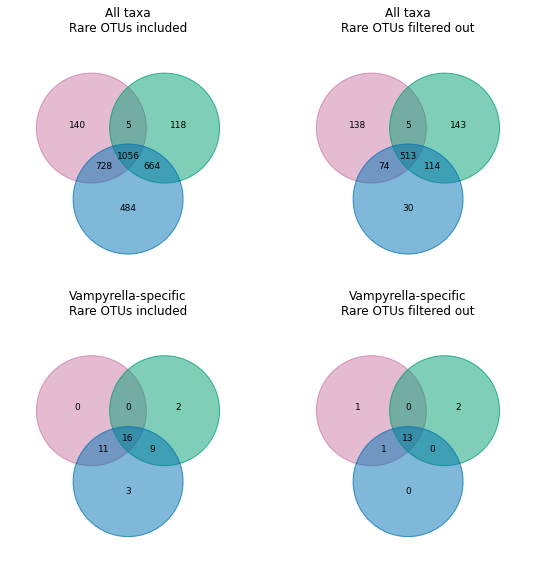

In [57]:
# venn diagram using the pyvenn library: https://pypi.org/project/venn/

from matplotlib.colors import ListedColormap
path="../raw_data/OTU_summary_tables"
dataset_labels=["all_otu_unfilt", "all_otu_filt", "vamp_otu_filt", "vamp_otu_filt"]
axes_labels=["ax1", "ax2", "ax3", "ax4"]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(8,8))

# all otus, rare OTUs rertained
all_otu_unfilt_c = venn(venn_datasets["all_otu_unfilt"],
                      alpha=0.5,
                      figsize=(10, 5),
                      fontsize=9,
                      legend_loc=None,
                      cmap=ListedColormap(["#CC79A7", "#009E73", "#0072B2"]),
                      ax=ax1)
ax1.set_title("All taxa\nRare OTUs included", pad=5)


# all otus, rare OTUs filtrated
all_otu_filt_c = venn(venn_datasets["all_otu_filt"],
                      alpha=0.5,
                      figsize=(10, 5),
                      fontsize=9,
                      legend_loc=None,
                      cmap=ListedColormap(["#CC79A7", "#009E73", "#0072B2"]),
                      ax=ax2)
ax2.set_title("All taxa\nRare OTUs filtered out", pad=5)


# vampyrella otus, rare OTUs retained
vamp_otu_filt_c = venn(venn_datasets["vamp_otu_unfilt"],
                      alpha=0.5,
                      figsize=(10, 5),
                      fontsize=9,
                      legend_loc=None,
                      cmap=ListedColormap(["#CC79A7", "#009E73", "#0072B2"]),
                      ax=ax3)
ax3.set_title("Vampyrella-specific\nRare OTUs included", pad=5)

# vampyrella otus, rare OTUs filtrated
vamp_otu_filt_c = venn(venn_datasets["vamp_otu_filt"],
                      alpha=0.5,
                      figsize=(10, 5),
                      fontsize=9,
                      legend_loc=None,
                      cmap=ListedColormap(["#CC79A7", "#009E73", "#0072B2"]),
                      ax=ax4)
ax4.set_title("Vampyrella-specific\nRare OTUs filtered out", pad=5)

# plt.subplots_adjust(top=1.01, bottom=1) 

plt.tight_layout()

# save
plt.savefig(f"{path}/venn_datasets_sim99.png", dpi=300, transparent=False, facecolor='white')

In [ ]:
# creating tabels with OTU ID and dataset name columns for sim99 datasets
# we will use the OTU IDs in the next step to find out which OTUs are unique and which are shared across the datasets

# choose if you want to continue with all OTUs or just vampyrella specific OTUs
sum_tables=sum_tables_vamp_unfilt

datasets={}
dataset_labels=["cell1_sim99", "cell2_sim99", "cellCombined_sim99"]

for dataset in dataset_labels:
    sum_tables[dataset]["dataset"]=f"{dataset}"
    datasets[dataset]=sum_tables[dataset][["ID", "dataset"]]

In [ ]:
# creating tabels with OTU ID and dataset name columns for sim99 datasets
# we will use the OTU IDs in the next step to find out which OTUs are unique and which are shared across the datasets

# choose if you want to continue with all OTUs or just vampyrella specific OTUs
sum_tables=sum_tables_vamp_unfilt

datasets={}
dataset_labels=["cell1_sim99", "cell2_sim99", "cellCombined_sim99"]

for dataset in dataset_labels:
    sum_tables[dataset]["dataset"]=f"{dataset}"
    datasets[dataset]=sum_tables[dataset][["ID", "dataset"]]

In [ ]:
# create a dataframe for venn diagrams
venn_table=venn_df(datasets)

In [ ]:
# checking the number of shared and unique OTUs between datasets
venn_table[(venn_table["cell1_sim99"] == 1) & 
           (venn_table["cell2_sim99"] == 0) & 
           (venn_table["cellCombined_sim99"] == 1)]